## Construção do modelo de classificação:
Implementar um modelo de clustering usando o algoritmo K-Means para segmentar os clientes em grupos homogêneos baseados em suas características demográficas e comportamentais.

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.combine import SMOTETomek

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder, 
    MinMaxScaler, 
    OrdinalEncoder,
    OneHotEncoder, 
    PowerTransformer,
    StandardScaler,
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

#estudo knn
from sklearn.neighbors import KNeighborsClassifier

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_LIMPOS,  MODELO
from src.graficos_s import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_smoteenn import RANDOM_STATE
from src.models_smoteenn import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)


sns.set_theme(palette='viridis')


In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,Idade,Attrition,Viagens trab,Tarifa diária,Departamento,Distância casa,Formação acad,Área form,Satisf amb,Gênero,...,Avaliação desemp,Satisf relac,Opc ações,Anos traba,Treinam ultm ano,Equil vida-trab,Anos empresa,Anos cargo atual,Anos ult prom,Anos gerente atual
0,41,Sim,Viaja_raramente,1102,Vendas,1.60934,2,Ciências biológicas,2,Feminino,...,3,1,0,8,0,1,6,4,0,5
1,49,Não,Viaja_frequentemente,279,Pesquisa e Desenvolvimento,12.87472,1,Ciências biológicas,3,Masculino,...,4,4,1,10,3,3,10,7,1,7
2,37,Sim,Viaja_raramente,1373,Pesquisa e Desenvolvimento,3.21868,2,Outros,4,Masculino,...,3,2,0,7,3,3,0,0,0,0
3,33,Não,Viaja_frequentemente,1392,Pesquisa e Desenvolvimento,4.82802,4,Ciências biológicas,4,Feminino,...,3,3,0,8,3,3,8,7,3,0
4,27,Não,Viaja_raramente,591,Pesquisa e Desenvolvimento,3.21868,1,Ciências médicas,1,Masculino,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Idade               1470 non-null   int64  
 1   Attrition           1470 non-null   object 
 2   Viagens trab        1470 non-null   object 
 3   Tarifa diária       1470 non-null   int64  
 4   Departamento        1470 non-null   object 
 5   Distância casa      1470 non-null   float64
 6   Formação acad       1470 non-null   int64  
 7   Área form           1470 non-null   object 
 8   Satisf amb          1470 non-null   int64  
 9   Gênero              1470 non-null   object 
 10  Tarifa hora         1470 non-null   int64  
 11  Envolv trab         1470 non-null   int64  
 12  Nível cargo         1470 non-null   int64  
 13  Cargo               1470 non-null   object 
 14  Satisf trab         1470 non-null   int64  
 15  Estado civil        1470 non-null   object 
 16  Renda 

In [4]:
# Agrupamento das colunas de acordo com o pré-processamento necessário
colunas_categoricas_nao_ordenadas = [
    'Viagens trab',
    'Departamento',
    'Área form',
    'Gênero',
    'Cargo',
    'Estado civil',
    'Hora extra'
]
colunas_categoricas_ordenadas = [
    'Satisf amb',
    'Formação acad',
    'Satisf trab',
    'Envolv trab',
    'Nível cargo',
    'Avaliação desemp',
    'Satisf relac',
    'Opc ações',
    'Equil vida-trab',
     
]
coluna_target= ['Attrition']

colunas_numericas = [coluna for coluna in df.columns if coluna not in (
    colunas_categoricas_nao_ordenadas+colunas_categoricas_ordenadas+coluna_target)
                              ]
colunas_numericas

['Idade',
 'Tarifa diária',
 'Distância casa',
 'Tarifa hora',
 'Renda mensal',
 'Tarifa mensal',
 'Nº empresas trab',
 '% aumento sal',
 'Anos traba',
 'Treinam ultm ano',
 'Anos empresa',
 'Anos cargo atual',
 'Anos ult prom',
 'Anos gerente atual']

Na EDA foi possível perceber que algumas colunas numéricas tinham uma distribuição bem distinta, que não se aproximava a distribuição normal: 'DailyRate', 'HourlyRate', 'MonthlyRate'. Nesses casos vou usar o MinMaxScaler para trabalhar o escalonamento sem focar na distribuição.
A coluna Age apresenta uma distribuição próxima do normal, por isso vou usar o StandarScaler e para as demais usarei o PowerTransformer para transformar os valores em uma distribuição mais normal.


In [5]:
colunas_numericas_min_max = [ coluna for coluna in df.filter(like='Tarifa').columns]
colunas_numericas_min_max

coluna_numerica_std= ['Idade']
colunas_numericas_power_transformer= [coluna for coluna in colunas_numericas if coluna not in (
    coluna_numerica_std +colunas_numericas_min_max)
]
colunas_numericas_power_transformer

['Distância casa',
 'Renda mensal',
 'Nº empresas trab',
 '% aumento sal',
 'Anos traba',
 'Treinam ultm ano',
 'Anos empresa',
 'Anos cargo atual',
 'Anos ult prom',
 'Anos gerente atual']

In [6]:
X= df.drop(columns=coluna_target)
y= df[coluna_target]


In [7]:
#codificação da coluna target
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())
y

array([1, 0, 1, ..., 0, 0, 0])

In [8]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

Fluxo da Análise:
1. Pré-processamento dos Dados:
Transformação de Variáveis:

Variáveis categóricas são codificadas via OneHotEncoder

Variáveis numéricas serão escalonadas


In [9]:
# Preprocessamento
preprocessamento = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ('ordinal', OrdinalEncoder(categories='auto'),colunas_categoricas_ordenadas),
        ('min_max', MinMaxScaler(), colunas_numericas_min_max),
        ('standard', StandardScaler(), coluna_numerica_std),
        ('power_transformer', PowerTransformer(), colunas_numericas_power_transformer)
    ]
)


In [10]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": preprocessamento,
        "classificador": DummyClassifier(strategy="stratified")
    },
    
     "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression()
    },
     
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC()
    },

     "KneighborsClassifier":{
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier()
           
    }, 
  
    # modelos baseado em árvores de decisão

      "DecisionTreeClassifier": {
        "preprocessor": preprocessamento,
        "classificador": DecisionTreeClassifier()
    },

    
     "XGBClassifier": {
        "preprocessor": preprocessamento,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
        )
     },

    "LGBMClassifier": {
        "preprocessor": preprocessamento,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        )
    }, 
   
}

In [11]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.714231,0.064731,0.530612,0.59375,0.323529,0.211538,0.6875,0.455793,0.153177,0.778962
1,DummyClassifier,0.160898,0.06891,0.585034,0.609502,0.336957,0.227941,0.645833,0.527439,0.171403,0.229808
2,DummyClassifier,0.168122,0.064088,0.52381,0.509863,0.247312,0.165468,0.489362,0.63903,0.215021,0.232209
3,DummyClassifier,0.18332,0.068815,0.517007,0.548884,0.282828,0.18543,0.595745,0.533681,0.169942,0.252135
4,DummyClassifier,0.190842,0.064766,0.482993,0.485572,0.232323,0.152318,0.489362,0.53213,0.169565,0.255608
5,LogisticRegression,0.372467,0.066,0.772109,0.738059,0.496241,0.388235,0.6875,0.823764,0.569604,0.438467
6,LogisticRegression,0.394347,0.068873,0.751701,0.71748,0.467153,0.359551,0.666667,0.816057,0.569005,0.463221
7,LogisticRegression,0.331587,0.072853,0.751701,0.731631,0.47482,0.358696,0.702128,0.831424,0.641622,0.40444
8,LogisticRegression,0.336203,0.075864,0.789116,0.77974,0.537313,0.413793,0.765957,0.832716,0.60937,0.412066
9,LogisticRegression,0.303933,0.068871,0.789116,0.771126,0.530303,0.411765,0.744681,0.801964,0.588833,0.372804


In [12]:
#vou usar a métrica average_precision por combinar as métricas precisão e recall dando peso a ambas.
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.283483,0.066262,0.527891,0.549514,0.28459,0.188539,0.58156,0.537615,0.175822,0.349744
DecisionTreeClassifier,0.256152,0.080836,0.778231,0.61915,0.35925,0.337387,0.384309,0.61915,0.231501,0.336987
KneighborsClassifier,0.194314,0.100436,0.641497,0.634659,0.361852,0.255579,0.624557,0.685451,0.275121,0.29475
SVC,0.431221,0.211413,0.813605,0.704894,0.485692,0.439422,0.544415,0.782049,0.535695,0.642633
LGBMClassifier,2.004419,0.07955,0.862585,0.659108,0.454633,0.631413,0.358777,0.801582,0.541333,2.083969
XGBClassifier,0.8985,0.074676,0.856463,0.648563,0.433564,0.604271,0.341755,0.800558,0.545272,0.973177
LogisticRegression,0.347707,0.070492,0.770748,0.747607,0.501166,0.386408,0.713387,0.821185,0.595687,0.4182


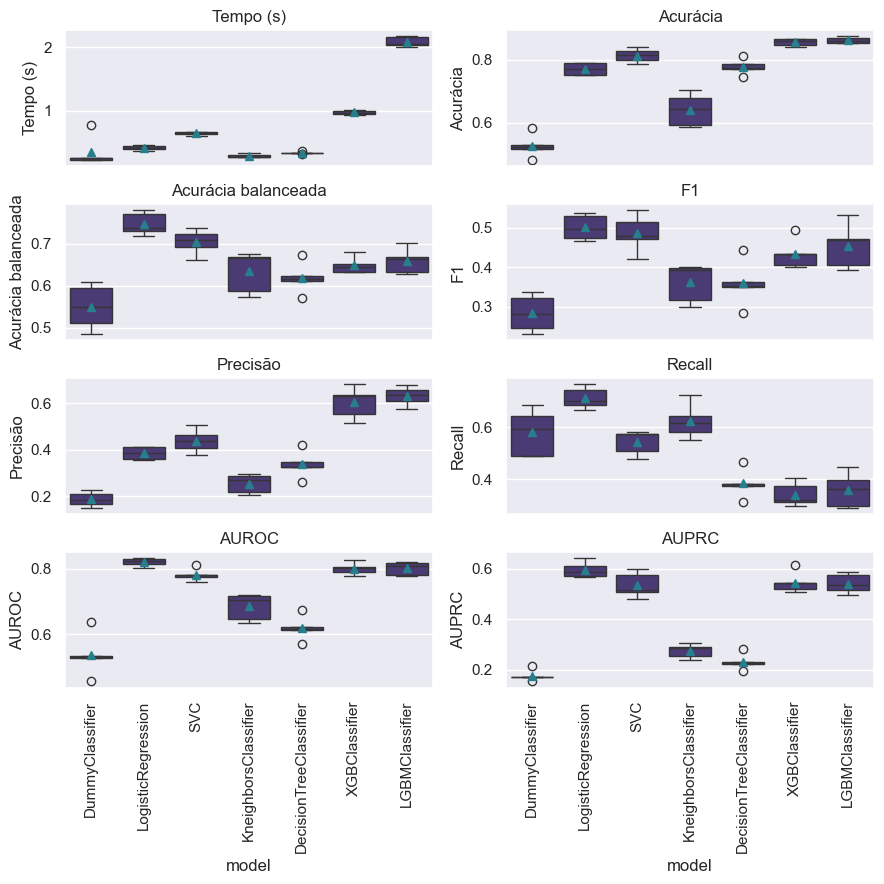

In [13]:
plot_comparar_metricas_modelos(df_resultados)

3. Aplicação da Regressão Logística:
   
Modelo treinado com n_clusters=5 e random_state=42 para reprodutibilidade

Pipeline integrando pré-processamento e modelagem

In [14]:
#como eu vou testar todos os solvers, receberei diversos avisos, uma vez que apenas o saga é compatível como o ElasticNet
param_grid= {
    "clf__C":[0.1, 1, 10],
    "clf__penalty": ['l1','l2', 'elasticnet', None],
    'clf__l1_ratio': [0.1, 0.25, 0.5],
    'clf__solver': ['liblinear','saga'],
}

In [15]:
clf = LogisticRegression(random_state=RANDOM_STATE, solver='saga') #para base de dado grande, o saga é indicado
grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, preprocessamento, refit_metric = "average_precision", 
)
grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Viagens '
                                                                          'trab',
                                                                          'Departamento',
                                                                          'Área '
                                                                          'form',
                                                                          'Gênero',
                                                                          'Cargo',
                                                                          'Estado '
                                                                          'civil',
                                                                          'Hora '
                                                                          'extra']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Satisf '
                                                                          'amb',
                                                                          'Formação '
                                                                          'acad',
                                                                          'Satisf '
                                                                          't...
                                       ('sampler', SMOTETomek(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [16]:
grid_search.fit(X,y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


D:\ProgramFiles\anaconda\env\machine_learning\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Viagens '
                                                                          'trab',
                                                                          'Departamento',
                                                                          'Área '
                                                                          'form',
                                                                          'Gênero',
                                                                          'Cargo',
                                                                          'Estado '
                                                                          'civil',
                                                                          'Hora '
                                                                          'extra']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Satisf '
                                                                          'amb',
                                                                          'Formação '
                                                                          'acad',
                                                                          'Satisf '
                                                                          't...
                                       ('sampler', SMOTETomek(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [17]:
grid_search.best_params_
#L1_ratio só faz sentido com Elastic Net

{'clf__C': 0.1, 'clf__l1_ratio': 0.1, 'clf__penalty': 'l1'}

In [18]:
grid_search.best_score_

0.6220287949852339

In [19]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Viagens trab',
                                                   'Departamento', 'Área form',
                                                   'Gênero', 'Cargo',
                                                   'Estado civil',
                                                   'Hora extra']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Satisf amb',
                                                   'Formação acad',
                                                   'Satisf trab', 'Envolv trab',
                                                   'Nível cargo',
                                                   'Avaliação desemp',
                                                   'Satisf relac', 'Opc ações',
                                                   'Equil vida-trab']),
                                                 ('mi...
                                                 ('standard', StandardScaler(),
                                                  ['Idade']),
                                                 ('power_transformer',
                                                  PowerTransformer(),
                                                  ['Distância casa',
                                                   'Renda mensal',
                                                   'Nº empresas trab',
                                                   '% aumento sal',
                                                   'Anos traba',
                                                   'Treinam ultm ano',
                                                   'Anos empresa',
                                                   'Anos cargo atual',
                                                   'Anos ult prom',
                                                   'Anos gerente atual'])])),
                ('sampler', SMOTETomek(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='l1',
                                    random_state=42, solver='saga'))])

In [20]:
#avaliar oos resultados de outras métricas e o desvio padrão
colunas_teste= [coluna for coluna in df_resultados.columns if coluna.startswith('test')]
colunas_teste


['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [21]:
colunas_test_mean = ['mean_'+coluna for coluna in colunas_teste]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [22]:
cv_results = pd.DataFrame(grid_search.cv_results_)

cv_results = cv_results[colunas_test_mean].iloc[grid_search.best_index_ , :]

cv_results.T

mean_test_accuracy             0.780272
mean_test_balanced_accuracy    0.758309
mean_test_f1                   0.516122
mean_test_precision            0.400489
mean_test_recall               0.725887
mean_test_roc_auc              0.824166
mean_test_average_precision    0.622029
Name: 0, dtype: float64

In [23]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_['clf'].coef_[0],
    grid_search.best_estimator_['preprocessor'].get_feature_names_out() #o nome das features
)
coefs  

,coeficiente
power_transformer__Anos traba,-0.518104
ordinal__Envolv trab,-0.434194
ordinal__Satisf amb,-0.382931
ordinal__Satisf trab,-0.337816
power_transformer__Renda mensal,-0.328389
one_hot__Estado civil_Divorciado,-0.311645
ordinal__Opc ações,-0.254414
ordinal__Satisf relac,-0.220398
power_transformer__Anos cargo atual,-0.208243
ordinal__Equil vida-trab,-0.196045


In [24]:
coeficientes_pouca_relev = coefs.query("coeficiente == 0")
coeficientes_pouca_relev

,coeficiente
one_hot__Cargo_Executivo de vendas,0.0
one_hot__Departamento_Recursos Humanos,0.0
one_hot__Área form_Ciências médicas,0.0
min_max__Tarifa mensal,0.0
min_max__Tarifa hora,0.0
one_hot__Área form_Marketing,0.0
one_hot__Cargo_Diretor de produção,0.0
ordinal__Avaliação desemp,0.0
one_hot__Área form_Recursos Humanos,0.0
one_hot__Área form_Outros,0.0


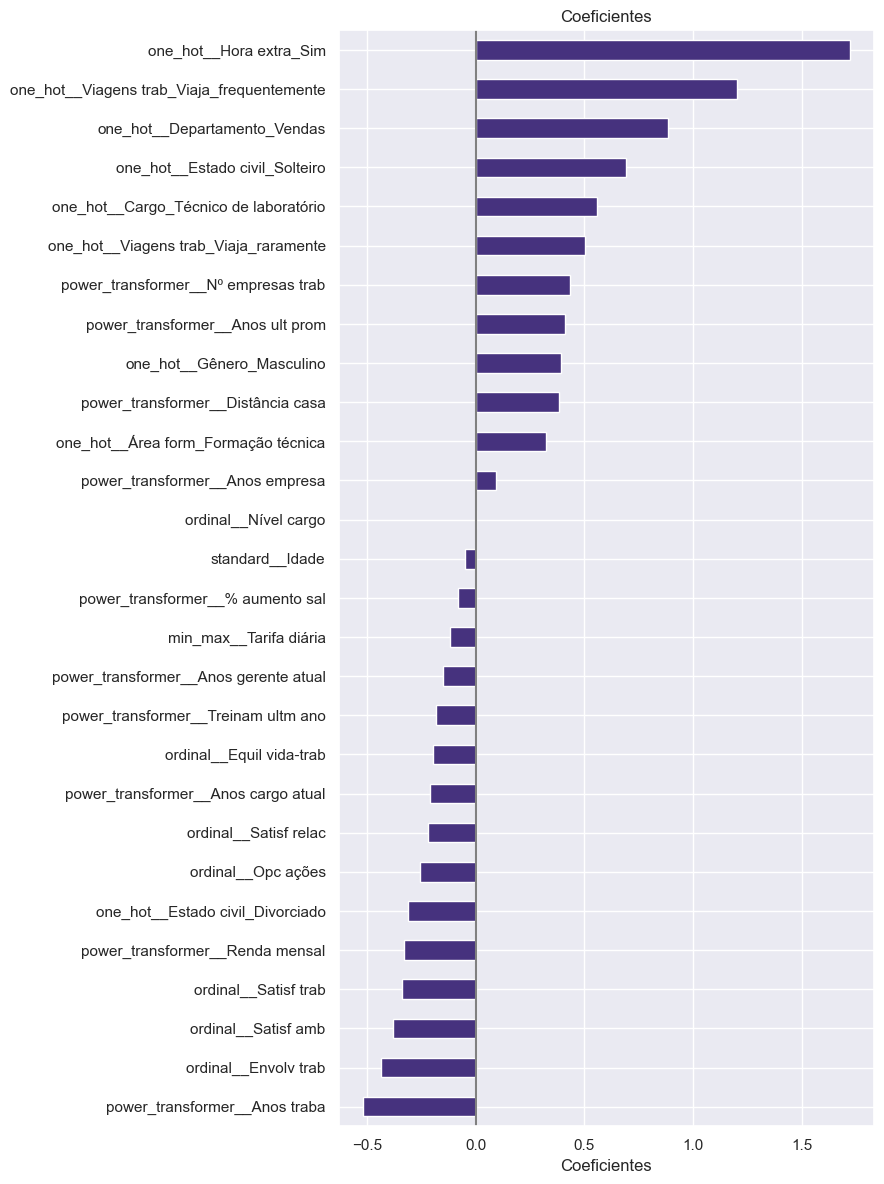

In [25]:
plot_coeficientes(coefs.query('coeficiente != 0'))

O Departamento de Pesquisa e Desenvolvimento tem mais pessoas e isso pode influenciar o resultado
Os coeficientes hora extra, viagem a trabalho frequentemente, pessoas solteiras e pessoas com formação técnica são mais altos em relação ao attrition

In [ ]:
Transformar em odds para facilitar o entendimento

In [26]:
coefs_odds = coefs.copy()
coefs_odds["coeficiente"] = np.exp(coefs_odds["coeficiente"])

coefs_odds['coeficiente'].sort_values(ascending=False)

one_hot__Hora extra_Sim                       5.589009
one_hot__Viagens trab_Viaja_frequentemente    3.328949
one_hot__Departamento_Vendas                  2.417334
one_hot__Estado civil_Solteiro                1.993852
one_hot__Cargo_Técnico de laboratório         1.746294
one_hot__Viagens trab_Viaja_raramente         1.653334
power_transformer__Nº empresas trab           1.542145
power_transformer__Anos ult prom              1.508031
one_hot__Gênero_Masculino                     1.479245
power_transformer__Distância casa             1.467963
one_hot__Área form_Formação técnica           1.378995
power_transformer__Anos empresa               1.099904
ordinal__Nível cargo                          1.002265
one_hot__Área form_Recursos Humanos           1.000000
one_hot__Cargo_Representante de vendas        1.000000
one_hot__Cargo_Representante de saúde         1.000000
one_hot__Cargo_Diretor de pesquisa            1.000000
one_hot__Cargo_Recursos Humanos               1.000000
one_hot__C

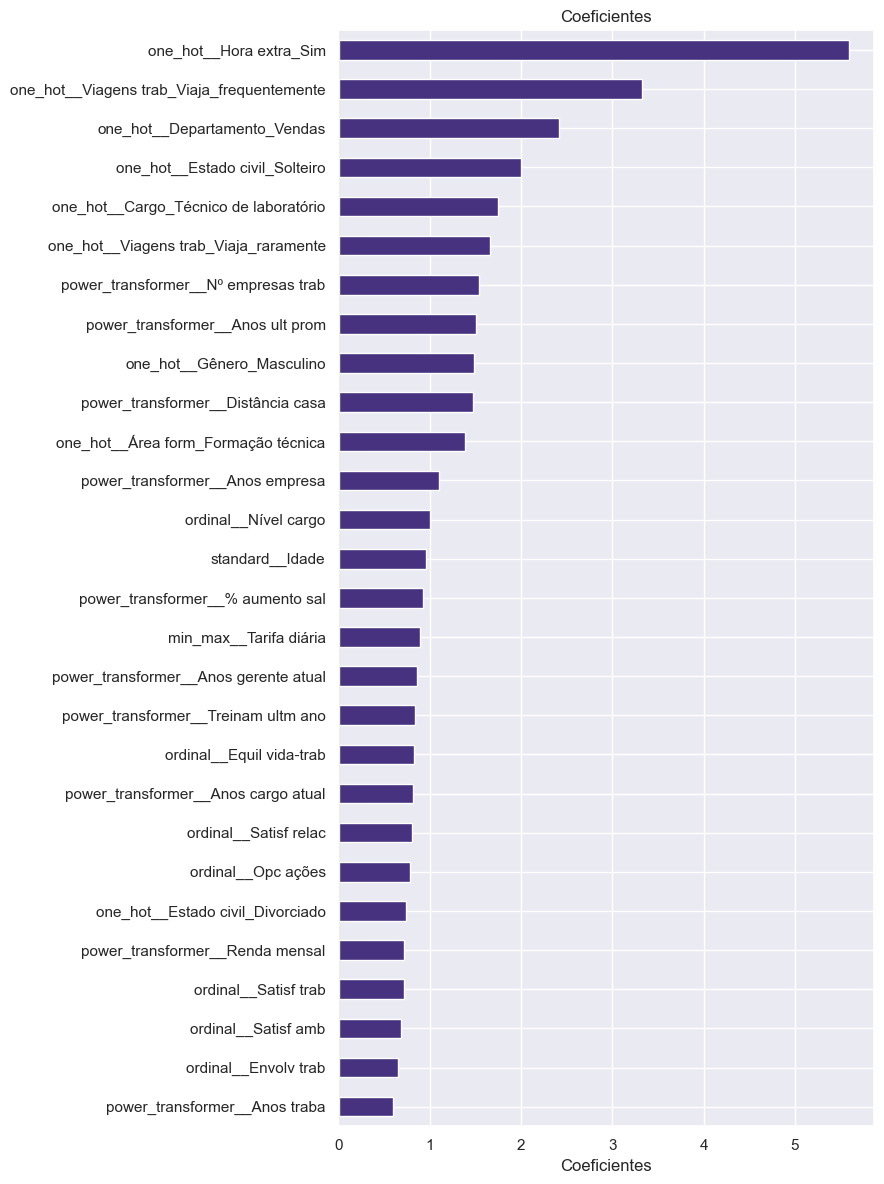

In [27]:
plot_coeficientes(coefs_odds.query("coeficiente != 1"))

Os funcionários que fazem hora extra com frequência tem 3.8 x mais chance de pedir demissão, seguido por quem viagem frequentemente( 2.11) e por quem é solteiro (1.83) em relação aos que não fazem.
Os funcionários que  se sentem envolvidos com o trabalho, com a renda mensal alta e satisfação com o ambiente de trabalho possuem 0.6x menos chance de pedir demissão em relação aos demais


<function matplotlib.pyplot.show(close=None, block=None)>

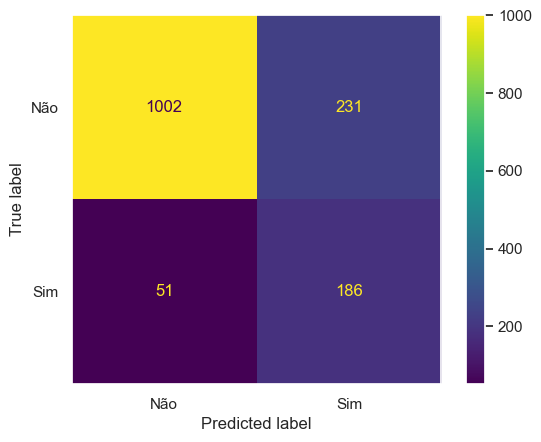

In [28]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,

)
plt.grid(False)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

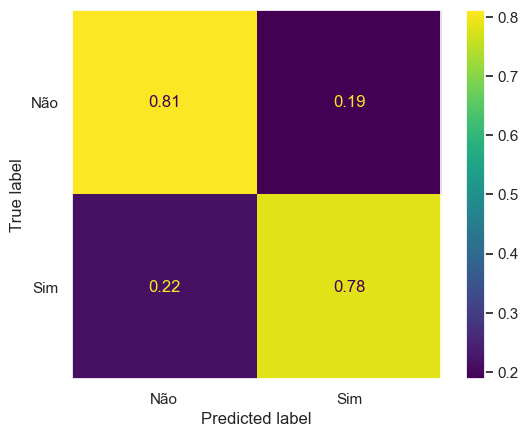

In [29]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize='true',

)
plt.grid(False)
plt.show

In [30]:
joblib.dump(grid_search, MODELO)


['D:\\ciencias_dados\\python_pratica\\hashtag\\ciencias_dados\\machine_learning\\projeto_ibm\\modelos\\modelo.pkl']

## Conclusão

O modelo identificou 5 clusters com perfis distintos:

Cluster 2 (19.5%): Alto potencial (alta renda + alto gasto) → Priorizar campanhas premium.

Cluster 4 (26.5%): Renda e gastos moderados + idade alta → Oferecer produtos de valor intermediário.

Cluster 1 (10%): Baixa renda e gastos → Evitar investimentos pesados.

Validação:

Diferenças por gênero foram observadas (ex.: Cluster 0 com 60% mulheres).

Aplicação:

Essa segmentação permite personalizar estratégias de marketing e otimizar alocação de recursos.

Plano de ação

Avaliar os motivos que levam os funcionários a fazerem hora extra.
    Mão de obra insuficiente
    Falta de organização institucional
    Falta de treinamento
    Necessidade de investimento em tecnologia
Possibilidade de diminuir as viagens de negócios.
    Como isso afeta a equipe de vendas?
Como a renda mensal de cada setor e nível da empresa se compara com o mercado?
Ações voltadas para o clima organizacional 
